<a href="https://colab.research.google.com/github/captain-pool/hub/blob/add_ESRGAN_colab/examples/colab/image_enhancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the \"License\");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

In [0]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

### Image Super Resolution using ESRGAN

This colab demonstrates use of TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)]

for image enhancing. *(Preferrably bicubically downsampled images).*

Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

**Preparing Environment**

In [0]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
tf.enable_v2_behavior()
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [2]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2019-08-22 19:30:38--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0s      

2019-08-22 19:30:38 (71.6 MB/s) - ‘original.png’ saved [34146/34146]



In [0]:
# Declaring Constants
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://github.com/captain-pool/GSOC/releases/download/1.0.0/esrgan.tar.gz"

**Defining Helper Functions**

In [0]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)


In [0]:
% matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#### Performing Super Resolution of images loaded from path

In [0]:
hr_image = preprocess_image(IMAGE_PATH)

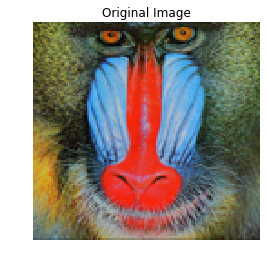

In [7]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")

In [8]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://github.com/captain-pool/GSOC/releases/download/1.0.0/esrgan.tar.gz, Total size: 20.94MB



In [9]:
start = time.time()
fake_image = model.call(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 4.833855


Saved as Super Resolution.jpg


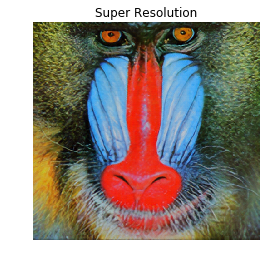

In [10]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

### Evaluating Performance of the Model

In [11]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

--2019-08-22 19:32:11--  https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64
Resolving lh4.googleusercontent.com (lh4.googleusercontent.com)... 172.217.25.225, 2404:6800:4004:81b::2001
Connecting to lh4.googleusercontent.com (lh4.googleusercontent.com)|172.217.25.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84897 (83K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  82.91K  --.-KB/s    in 0.07s   

2019-08-22 19:32:12 (1.11 MB/s) - ‘test.jpg’ saved [84897/84897]



In [0]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  _can_calculate_psnr = False
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
    _can_calculate_psnr = not (image_size[0] % 4 or image_size[1] % 4)
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))
  
  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image, _can_calculate_psnr

In [0]:
hr_image = preprocess_image(IMAGE_PATH)

In [0]:
lr_image, _can_calculate_psnr = downscale_image(tf.squeeze(hr_image))

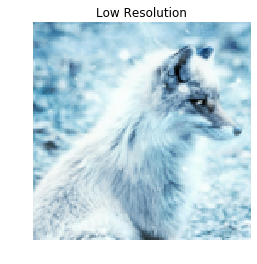

In [15]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [0]:
model = hub.load(SAVED_MODEL_PATH)

In [17]:
start = time.time()
fake_image = model.call(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.594690


PSNR Achieved: 28.029171


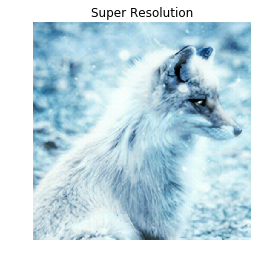

In [18]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
if _can_calculate_psnr:
  print("PSNR Achieved: %f" % tf.image.psnr(
      tf.clip_by_value(fake_image, 0, 255),
      tf.clip_by_value(hr_image, 0, 255), max_val=255))

**Comparing Outputs size by side.**

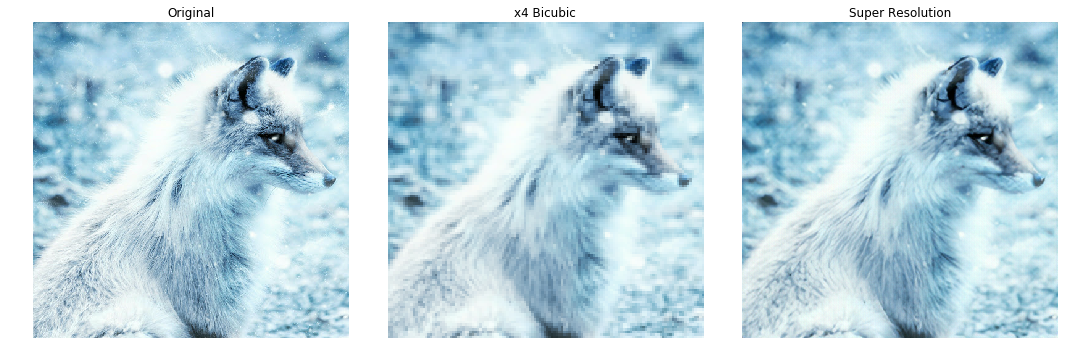

In [19]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")